<h1>Assessing Model Complexity</h1>
<h4>Editor: Daniel Wang</h4>

In the deep neural network domain, training on a deeper neural architecture often yields a better result, since deeper hidden layers can capture more complex features. However, is it true regardless of any other factors? So in this project, I will try to investigate whether a more complex DNN will always yield better performance.

In [8]:
import tensorflow as tf
import numpy as np

In this project, I will use a subset of the MNIST training dataset, since training DNNs on the whole MNIST dataset often yield accuracy higher than 99%, which makes us hard to tell whether a model is better or not.
<br>
In this case, I only choose 2000 samples for training. Besides, I will try to resize the image from 28x28 into 32x32, for some of our models used later on are required to have an input image size of at least 32x32.

In [9]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32, 32]) / 255.
x_train = x_train[:2000]

y_train = y_train[:2000]
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32, 32]) / 255.

y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (2000, 32, 32, 1)
y_train (2000, 10)
x_test (10000, 32, 32, 1)
y_test (10000, 10)


Let's visualize some sample images.

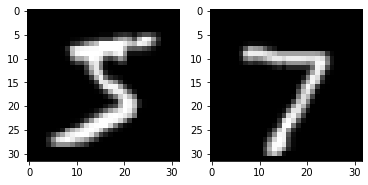

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)
axes[0].imshow(x_train[0,:,:,0], cmap="gray")
axes[1].imshow(x_test[0,:,:,0], cmap="gray")

In this project, I will use three kinds of different deep neural networks:
<ol>
  <li>Customize CNN (inspired from VGG, the simplest model here)</li>
  <li>DesneNet-121</li>
  <li>ResNet-152</li>
</ol>

In [11]:
model1 = tf.keras.Sequential([
  tf.keras.Input(shape=(32, 32, 1)),
  tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(10, activation="softmax"),
])
model2 = tf.keras.applications.DenseNet121(weights=None, input_shape=(32, 32, 1), classes=10)
model3 = tf.keras.applications.ResNet152(weights=None, input_shape=(32, 32, 1), classes=10)
models = [model1, model2, model3]

Now we assess the number of parameters for each model. Since DenseNet and ResNet have a huge amount of neurons, I use logarithmic count for the y-axis.

Text(0.5, 1.0, 'Model parameter counts')

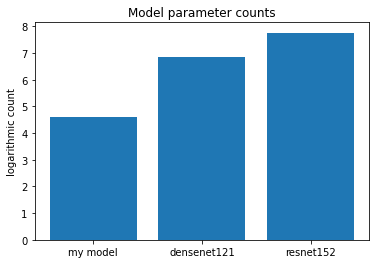

In [18]:
n_params = []
for model in models:
  n_params.append(np.log10(model.count_params()))

names = ["my model", "densenet121", "resnet152"]
plt.bar(names, n_params, align="center")
plt.ylabel("logarithmic count")
plt.title("Model parameter counts")

As we can see, DenseNet has approximately 100 times more parameters than our customized model, and ResNet even has 10 times more parameters than DenseNet.
<br>
Now let's train our model.



In [13]:
history_lst = []
for model in models:
  model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
  history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)
  history_lst.append(history)

Epoch 1/5
29/29 [==============================] - 1s 13ms/step - loss: 2.2972 - accuracy: 0.1189 - val_loss: 2.2388 - val_accuracy: 0.2950
Epoch 2/5
29/29 [==============================] - 0s 5ms/step - loss: 2.2384 - accuracy: 0.1855 - val_loss: 2.1699 - val_accuracy: 0.4850
Epoch 3/5
29/29 [==============================] - 0s 5ms/step - loss: 2.1671 - accuracy: 0.2957 - val_loss: 2.0746 - val_accuracy: 0.5800
Epoch 4/5
29/29 [==============================] - 0s 5ms/step - loss: 2.0640 - accuracy: 0.3688 - val_loss: 1.9046 - val_accuracy: 0.6250
Epoch 5/5
29/29 [==============================] - 0s 5ms/step - loss: 1.8728 - accuracy: 0.4736 - val_loss: 1.6361 - val_accuracy: 0.6400
Epoch 1/5
29/29 [==============================] - 13s 180ms/step - loss: 2.0422 - accuracy: 0.3084 - val_loss: 2.3033 - val_accuracy: 0.1200
Epoch 2/5
29/29 [==============================] - 2s 61ms/step - loss: 0.8533 - accuracy: 0.7604 - val_loss: 2.3136 - val_accuracy: 0.1150
Epoch 3/5
29/29 [=====

After training is done, let's check the accuracy of training data and validation data, respectively.

Text(0.5, 0.98, 'Performance Comparison')

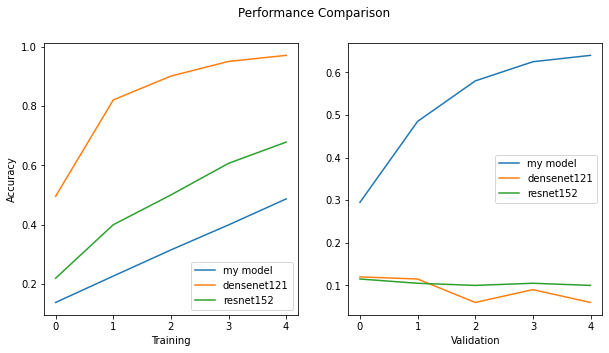

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for name, history in zip(names, history_lst):
  axes[0].plot(history.history['accuracy'], label=name)
  axes[1].plot(history.history['val_accuracy'], label=name)
axes[0].set_xlabel("Training")
axes[1].set_xlabel("Validation")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="best")
axes[1].legend(loc="best")
plt.suptitle("Performance Comparison")

From the above, we observe that although our customized model yields the worst accuracy on the training data, it **turns out** to have the best validation accuracy. This is the phenomenon of **overfitting** for the DenseNet and ResNet cases since their parameter counts are too high. 
<br>
To ensure this is the problem of overfitting, let's check the test set performance.

313/313 [==============================] - 10s 32ms/step - loss: 116.2906 - accuracy: 0.1013


Text(0.5, 1.0, 'Testing Result')

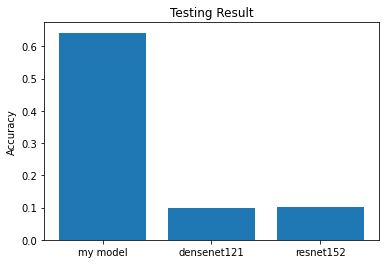

In [46]:
results = []
for model in models:
  score = model.evaluate(x_test, y_test)
  results.append(score[1])
plt.bar(names, results, align="center")
plt.ylabel("Accuracy")
plt.title("Testing Result")

As we can see, our simplest model **outperforms** the others. But, we shall not blame the designer of DenseNet and ResNet, since our training data is too small.
<br>
In the next section, I try to increase the training data size from 2000 to 10000, and I want to see if there is any difference.

In [47]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, axis=-1)
x_train = tf.image.resize(x_train, [32, 32]) / 255.
x_train = x_train[:10000]

y_train = y_train[:10000]
y_train = tf.keras.utils.to_categorical(y_train, 10)

x_test = np.expand_dims(x_test, axis=-1)
x_test = tf.image.resize(x_test, [32, 32]) / 255.

y_test = tf.keras.utils.to_categorical(y_test, 10)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10000, 32, 32, 1)
y_train (10000, 10)
x_test (10000, 32, 32, 1)
y_test (10000, 10)


And do something the same as before.

In [48]:
history_lst = []
for model in models:
  model.compile(loss="categorical_crossentropy", optimizer="sgd", metrics=["accuracy"])
  history = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)
  history_lst.append(history)

Epoch 1/5
141/141 [==============================] - 1s 6ms/step - loss: 1.4023 - accuracy: 0.5864 - val_loss: 0.6152 - val_accuracy: 0.8380
Epoch 2/5
141/141 [==============================] - 1s 4ms/step - loss: 0.7856 - accuracy: 0.7405 - val_loss: 0.4641 - val_accuracy: 0.8540
Epoch 3/5
141/141 [==============================] - 1s 4ms/step - loss: 0.6227 - accuracy: 0.7966 - val_loss: 0.3893 - val_accuracy: 0.8890
Epoch 4/5
141/141 [==============================] - 1s 4ms/step - loss: 0.5046 - accuracy: 0.8365 - val_loss: 0.3504 - val_accuracy: 0.8900
Epoch 5/5
141/141 [==============================] - 1s 4ms/step - loss: 0.4315 - accuracy: 0.8650 - val_loss: 0.3216 - val_accuracy: 0.9060
Epoch 1/5
141/141 [==============================] - 20s 86ms/step - loss: 0.2058 - accuracy: 0.9417 - val_loss: 2.2179 - val_accuracy: 0.1390
Epoch 2/5
141/141 [==============================] - 8s 60ms/step - loss: 0.0864 - accuracy: 0.9771 - val_loss: 0.5395 - val_accuracy: 0.8320
Epoch 3/5


Text(0.5, 0.98, 'Performance Comparison')

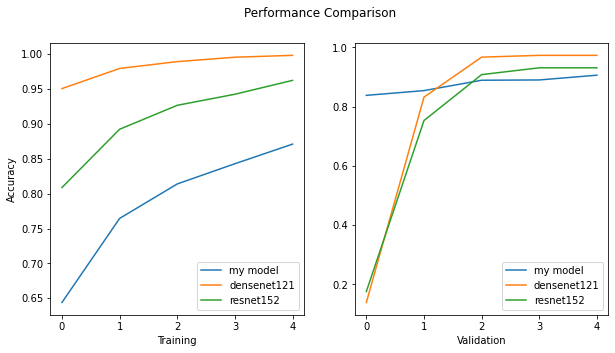

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for name, history in zip(names, history_lst):
  axes[0].plot(history.history['accuracy'], label=name)
  axes[1].plot(history.history['val_accuracy'], label=name)
axes[0].set_xlabel("Training")
axes[1].set_xlabel("Validation")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="best")
axes[1].legend(loc="best")
plt.suptitle("Performance Comparison")

Here, we see that DensetNet and ResNet not only perform better during the training stage, they also have a good performance on the validation stage after 2 epochs.
<br>
Finally, let's see the test set performance:

313/313 [==============================] - 10s 31ms/step - loss: 0.2479 - accuracy: 0.9260


Text(0.5, 1.0, 'Testing Result')

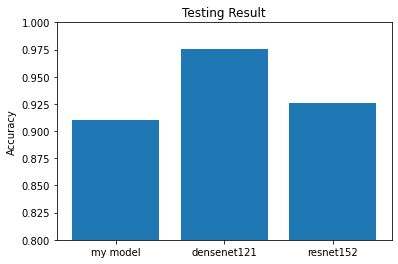

In [52]:
results = []
for model in models:
  score = model.evaluate(x_test, y_test)
  results.append(score[1])
plt.bar(names, results, align="center")
plt.ylabel("Accuracy")
plt.ylim((0.8, 1))
plt.title("Testing Result")

Compared to the data volume that has merely 2000, DenseNet and ResNet can perform well as long as the training data is sufficient enough. Therefore, we can conclude: 
<br>
<ol>
  <li>If data volume is <b>small</b>, we shall use <b>simpler</b> model for training in order to prevent overfitting.</li>
  <li>If we have <b>sufficient</b> training data, we could use <b>more complex</b> model in order to boost performance.</li>
</ol>